In [1]:
push!(LOAD_PATH,"../../../ExoJulia/")

include("../../hw2/Jake_Dave/utils.jl")
include("../../hw2/Jake_Dave/orbital_utils.jl")
include("../../hw2/Jake_Dave/rv.jl")
include("transit_utils.jl")

using ExoJulia
using PyPlot
using LsqFit
using Optim
using Lora

INFO: Recompiling stale cache file /Users/Jake/.julia/lib/v0.4/ColorTypes.ji for module ColorTypes.
INFO: Recompiling stale cache file /Users/Jake/.julia/lib/v0.4/PyPlot.ji for module PyPlot.
INFO: Recompiling stale cache file /Users/Jake/.julia/lib/v0.4/PyCall.ji for module PyCall.
INFO: Recompiling stale cache file /Users/Jake/.julia/lib/v0.4/Colors.ji for module Colors.
INFO: Recompiling stale cache file /Users/Jake/.julia/lib/v0.4/LaTeXStrings.ji for module LaTeXStrings.
//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
INFO: Recompiling stale cache file /Users/Jake/.julia/lib/v0.4/Optim.ji for module Optim.
INFO: Recompiling stale cache file /Users/Jake/.julia/lib/v0.4/Calculus.ji for module Calculus.
INFO: Recompiling stale cache file /Users/Jake/.julia/lib/v0.4/DualNumbers.ji

# Read in the data

In [2]:
data = readdlm("mystery_planet2.txt");
time = data[:,1];
flux = data[:,2];
mean_flux = flux/median(flux)
err = data[:,3];

# Bin the data (Not here)

# What's the data look like?

In [ ]:
scatter(time,mean_flux, color="blue", alpha=0.1)
ylim(0.995,1.005)

# Use Agol Periodogram to estimate the period

In [243]:
periods = collect(linspace(0.1,20.0,1000))

best_period = agol_periodogram(data, periods)

12.171471471471472

# Phase fold with the fitted period to see if it works.

In [ ]:
data_fold = copy(data)
data_fold[:,1] = mod(time - time[1], best_period);
data_fold = fastsortrows(data_fold,[1]);

In [ ]:
scatter(data_fold[:,1],data_fold[:,2]/mean(data_fold[:,2]),color="blue")
ylim(0.995,1.005)
#xlim(minimum(data_fold[:,1]),maximum(data_fold[:,1]))
xlim(0.25,1.5)

### We want to calculate the first time that elapses between the first observation and the center of the first transit, $t_{off}$.

In [4]:
function estimate_guess(time::Array{Float64,1},flux::Array{Float64,1},period::Float64)
    # Estimate 1st transit center
    best_ind = argmin(abs(time-period))
    toff_est_ind = argmin(flux[1:best_ind]) # <- this index ~ 1st transit center
    """
    #=
    cadence = 5
    avg_flux = [ mean(b[i:min(i+cadence-1,end)]) for i=1:cadence:length(b) ]
    
    # Estimate transit duration
    mf = median(flux)
    iter = 1
    T_right_ind = 1
    T_left_ind = 1
    
    # Find right edge of transit
    while abs(1.0 - flux[toff_est_ind+iter]/mf) > 0.001 && iter < length(flux)
        T_right_ind = toff_est_ind + iter
        iter = iter + 1
    end
    
    # Find left edge of transit
    while abs(1.0 - flux[toff_est_ind-iter]/mf) > 0.001 && iter > 0
        T_left_ind = toff_est_ind - iter
        iter = iter - 1
    end
    
    # Better estimate for transit center ind
    toff_est_ind = convert(Int,round((T_left_ind + T_right_ind)/2.0))
    
    # Use this to estimate depth assuming i ~ 90 degrees
    #tmp = 1.0 - flux[toff_est_ind]/mf
    tmp = 0.0
    """
    
    return time[toff_est_ind]
end

estimate_guess (generic function with 1 method)

In [5]:
best_toff = estimate_guess(time,mean_flux,best_period)

0.784

In [ ]:
scatter(time,mean_flux, color="blue", alpha=0.1)
scatter(best_toff, 1.0, alpha=1.0, color="k", label="First Transit Center")
ylim(0.995,1.005)
xlim(0.0, 3.0)
legend(loc=0)

# Transit logliklihood and forward model

In [ ]:
function transit_loglike(params::Vector)
    # params = [rp/rs, d, ecc, varpi, inc, period] where d = a/rstar
    
    # Hard bounds
    if params[1] < 0.0 || params[1] >= 0.1
        return Inf
    end
    if params[2] <= 0.0
        return Inf
    end
    if params[3] < 0.0 || params[3] >= 1.0
        return Inf
    end
    if(params[4] < 0.0) || (params[4] > 2.0*pi)
        return Inf
    end
    if (params[5] > (100.0*pi/180.0)) || (params[5] < (80.0*pi/180.0))
        return Inf
    end
    if(params[6] <= 0.0)
        return Inf
    end
    # Probability of transit must be between (0,1]
    if (1./params[2])*(params[1] + 1.)/(1.0-params[3]^2.) <= 0.0
        return Inf
    end
    if (1./params[2])*(params[1] + 1.)/(1.0-params[3]^2.) > 1.0
        return Inf
    end
    
    # Note: - because optim looks for MINIMUM!
    model = transit_model(time,params);
    
    return -loglike(mean_flux, model, err);
end

In [ ]:
function transit_model(time::Array{Float64,1},params::Vector)
    # params = [rp/rs, d, ecc, varpi, inc, period, tp] where d = a/rstar
    k = params[1]
    d = params[2]
    ecc = params[3]
    varpi = params[4] + pi/2.0 # rads
    inc = params[5]
    per = params[6]
    tp = params[7]
    
    #fi = 3.*pi/2 - varpi
    #tp = per*sqrt(1.-ecc*ecc)/(2.*pi)*(ecc*sin(fi)/(1.+ecc*cos(fi))-2./sqrt(1.-ecc*ecc)*atan2(sqrt(1.-ecc*ecc)*tan(fi/2.),1.+ecc))
    
    rel_flux = zeros(length(time))
    distance = 0.0
    for i=1:length(time)
        distance = center_separation(time[i],time[1]+tp,per,d,inc,ecc,varpi)
        rel_flux[i] = relative_flux(distance,k)
    end
    
    return rel_flux
end

# Transit logliklihood and forward model used for Lora MCMC fitting

In [ ]:
function transit_model_mcmc(time::Array{Float64,1},params::Vector)
    # params = [rp/rs, d, ecc, varpi, inc, period, tp] where d = a/rstar
    k = params[1]
    d = params[2]
    ecc = params[3]
    varpi = params[4] + pi/2.0 # rads
    inc = params[5]
    per = params[6]
    
    fi = 3.*pi/2 - varpi
    tp = per*sqrt(1.-ecc*ecc)/(2.*pi)*(ecc*sin(fi)/(1.+ecc*cos(fi))-2./sqrt(1.-ecc*ecc)*atan2(sqrt(1.-ecc*ecc)*tan(fi/2.),1.+ecc))
    
    rel_flux = zeros(length(time))
    distance = 0.0
    for i=1:length(time)
        distance = center_separation(time[i],time[1]+tp,per,d,inc,ecc,varpi)
        rel_flux[i] = relative_flux(distance,k)
    end
    
    return rel_flux
end

In [ ]:
function transit_loglike_mcmc(params::Vector)
    # params = [rp/rs, d, ecc, varpi, inc, period, tp] where d = a/rstar
    
    # Hard bounds
    if params[1] < 0.0 || params[1] >= 0.1
        return -Inf
    end
    if params[2] <= 0.0
        return -Inf
    end
    if params[3] < 0.0 || params[3] >= 1.0
        return -Inf
    end
    if(params[4] < 0.0) || (params[4] > 2.0*pi)
        return -Inf
    end
    if (params[5] > (105.0*pi/180.0)) || (params[5] < (75.0*pi/180.0))
        return -Inf
    end
    if params[6] <= (best_period - 0.1) || params[6] > (best_period + 0.1)
        return -Inf
    end
    
    # Probability of transit must be between (0,1]
    if (1./params[2])*(params[1] + 1.)/(1.0-params[3]^2.) <= 0.0
        return -Inf
    end
    if (1./params[2])*(params[1] + 1.)/(1.0-params[3]^2.) > 1.0
        return -Inf
    end
    
    # Note: - because optim looks for MINIMUM!
    model = transit_model_mcmc(time,params);
    
    return loglike(mean_flux, model, err);
end

function transit_loglike_optim(params::Vector)
    return -transit_loglike_mcmc(params)
end

# Try fitting this model with optim

In [ ]:
# [rp/rs, d, ecc, varpi, inc, period]
params = [0.05, 30.0, 0.1, 0.1, pi/2.0, best_period]
optimum = optimize(transit_loglike_optim, params, method=:bfgs)

In [ ]:
best_optim = optimum.minimum

# Try MCMC for orbital elements model

In [ ]:
p = BasicContMuvParameter(:p, logtarget=transit_loglike_mcmc)

model = likelihood_model(p, false)

# initial guess # params [rp/rs, d, ecc, varpi, inc, period]
params = [0.05, 20.0, 0.1, 0.1, pi/2.0, best_period]

sampler = MH(ones(length(params)))

N = 1000000
mcrange = BasicMCRange(nsteps=N, burnin=(N-10000))

v0 = Dict(:p=>params)

job = BasicMCJob(model, sampler, mcrange, v0, tuner=tuner=AcceptanceRateMCTuner(0.1, verbose=false))

run(job)

chain = output(job)

### Check that the simulated values are close to the zero-mean target

best_mcmc = mean(chain)

In [ ]:
time_hires = collect(linspace(minimum(time),maximum(time),100000))

scatter(time_hires,transit_model_mcmc(time_hires,best_mcmc),color="green", alpha=0.1)

scatter(time,mean_flux, color="blue", alpha=0.1)
ylim(0.995,1.005)

# Impact parameter formalization

In [ ]:
function impact_separation(b::Float64,t::Float64,v::Float64,P::Float64,toff::Float64)
    return sqrt(b.^2 + (v.*(mod(t,P)-toff)).^2)
end

In [ ]:
function transit_model_impact(time::Array{Float64,1},params::Vector)
    # params [rp/rs, b, v, period, toff]
    
    rel_flux = zeros(length(time))
    distance = 0.0
    for i=1:length(time)
        distance = impact_separation(params[2],time[i],params[3],params[4],params[5])
        rel_flux[i] = relative_flux(distance,params[1])
    end
    
    return rel_flux
end

In [ ]:
function transit_loglike_impact(params::Vector)
    # params [rp/rs, b, v, period, toff]
    A = 0.075
    B = 0.01
    C = 0.05
    
    # Hard bounds
    if params[1] < 0.0 || params[1] >= 0.1
        return -Inf
    end
    if params[2] < 0.0 || params[2] >= 1.0
        return -Inf
    end
    if params[3] < 0.1 || params[3] > 15.0
        return -Inf
    end
    if(params[4] < best_period - best_period*B) || (params[4] > best_period + best_period*B)
        return -Inf
    end
    if(params[5] < best_toff*(1.0-C)) || (params[5] > best_toff * (1.0+C))
        return -Inf
    end
    
    model = transit_model_impact(time,params);
    
    return loglike(mean_flux, model, err);
end

function transit_loglike_impact_optim(params::Vector)
    return -transit_loglike_impact(params)
end

# MCMC Fitting

In [ ]:
p = BasicContMuvParameter(:p, logtarget=transit_loglike_impact)

model = likelihood_model(p, false)

# initial guess # params [rp/rs, b, v, period, toff]
#params = [0.05, 0.5, 1.0, best_period, best_toff]
params = best_optim

sampler = MH(ones(length(params)))

N = 10000000
mcrange = BasicMCRange(nsteps=N, burnin=(N-10000))

v0 = Dict(:p=>params)

job = BasicMCJob(model, sampler, mcrange, v0, tuner=AcceptanceRateMCTuner(0.7, verbose=false))

run(job)

chain = output(job)

### Check that the simulated values are close to the zero-mean target

best_mcmc = mean(chain)

### But how does it look?

In [ ]:
time_hires = collect(linspace(minimum(time),maximum(time),100000))

scatter(time_hires,transit_model_impact(time_hires,best_mcmc),color="green", alpha=0.1)

scatter(time,mean_flux, color="blue", alpha=0.1)
ylim(0.995,1.005)
#xlim(0,2.5)

# Optim fitting

In [ ]:
# params = [rp/rs, b, v, period, toff] where d = a/rstar
params = [0.05, 0.2, 10.0, best_period, best_toff]
optimum = optimize(transit_loglike_impact_optim, params, method=:gradient_descent)

In [ ]:
# params = [rp/rs, d, ecc, varpi, inc, period] where d = a/rstar
best_optim = optimum.minimum

# Plot phase-folded light curve using best fit parameters

In [ ]:
data = [time mean_flux err];
data_fold = copy(data)
data_fold[:,1] = mod(time - time[1], best_optim[4]);
data_fold = convert(Array{Float64,2},fastsortrows(data_fold,[1]));

In [ ]:
scatter(data_fold[:,1],transit_model_impact(data_fold[:,1],best_optim),color="green")
scatter(data_fold[:,1],data_fold[:,2]/mean(data_fold[:,2]),color="blue",alpha=0.5)
ylim(0.995,1.005)
xlim(0.,1.5)

In [ ]:
time_hires = collect(linspace(minimum(time),maximum(time),100000))

scatter(time_hires,transit_model_impact(time_hires,best_optim),color="green", alpha=0.1)

scatter(time,mean_flux, color="blue", alpha=0.1)
ylim(0.995,1.005)
#xlim(0,2.5)

# Fit to observables formalization

## Building new model using Seager+ (2003)

In [6]:
"""
Observables
-----------
dF : Delta Flux = Rp/Rs
tT : Transit Duration
tF : Flat Duration 
P  : Period 
tE : Time of first transit
"""

function transit_velocity(tT::Float64, RpRs::Float64, b::Float64)
    # Calculates transit velocity (units of Rs/day) as a function of:
    # tT : Transit Duration
    # RpRs : Radius of planet / Radius of Star
    # b : Impact Parameter
    return 2.0 * (RpRs + 1.0) * sqrt(1.0 - b^2) / tT
end

function impact_parameter(dF::Float64, tF::Float64, tT::Float64, P::Float64)
    # Calculates impact parameter in terms of observables
    sinF2 = sin(pi * tF / P)^2;
    sinT2 = sin(pi * tT / P)^2;
    return (((1.0 - sqrt(dF))^2 - (sinF2/sinT2) * (1.0 + sqrt(dF))^2)/(1.0 - sinF2/sinT2))^0.5
end

function aRs(dF::Float64, tT::Float64, P::Float64, b::Float64)
    # Calculates a/Rs in terms of observables
    sinT2 = sin(pi * tT / P)^2;
    return (((1.0 + sqrt(dF))^2 - b^2*(1.0 - sinT2))/(sinT2))^0.5
end

function stellar_density(dF::Float64, tT::Float64, P::Float64, b::Float64)
    # Calculates the stellar density (units of solar density) in terms of observables
    Gterm = 365.25^2 / 215^3; # [day^2 Msun Rsun^-3]
    sinT2 = sin(pi * tT / P)^2;
    return ((Gterm)/(P^2))*(((1.0 + sqrt(dF))^2 - b^2*(1.0 - sinT2))/(sinT2))^1.5
end

stellar_density (generic function with 1 method)

In [166]:
function check_impact_params(params::Vector)
    # Returns false if params will crash the impact parameter calculation
    sinF2 = sin(pi * params[3] / params[4])^2;
    sinT2 = sin(pi * params[2] / params[4])^2;
    numerator = ((1.0 - sqrt(params[1]))^2 - (sinF2/sinT2) * (1.0 + sqrt(params[1]))^2)
    if numerator < 0.0
        return false
    else
        return true
    end 
end

check_impact_params (generic function with 1 method)

In [7]:
function impact_separation(b::Float64,t::Float64,v::Float64,P::Float64,toff::Float64)
    return sqrt(b.^2 + (v.*(mod(t,P)-toff)).^2)
end

impact_separation (generic function with 1 method)

In [32]:
function transit_model_observables(time::Array{Float64,1},params::Vector)
    #
    #Observables
    #-----------
    #dF : Delta Flux = Rp/Rs
    #tT : Transit Duration
    #tF : Flat Duration 
    #P  : Period 
    #tE : Time of first transit
    #
    
    # Write params (will want to remove this for less malloc)
    dF = params[1]
    tT = params[2]
    tF = params[3]
    P  = params[4]
    tE = params[5]
    
    # Calculate physical parameters from observables
    RpRs = sqrt(dF);
    b = impact_parameter(dF, tF, tT, P);
    vRs = transit_velocity(tT, RpRs, b);
    rhos = stellar_density(dF, tT, P, b);
    
    rel_flux = zeros(length(time))
    distance = 0.0
    for i=1:length(time)
        distance = impact_separation(b, time[i], vRs, P, tE);
        rel_flux[i] = relative_flux(distance,RpRs);
    end
    
    return rel_flux
end

transit_model_observables (generic function with 1 method)

In [178]:
function transit_loglike_observables(params::Vector)
    # params [ dF, tT, tF, P, tE ]
    #print(params)
    
    # Hard bounds
    if params[1] < 0.0 || params[1] > 0.5
        #print(1)
        return -Inf
    end
    if (params[2] < 0.0) || (params[2] > params[4])
        #print(2)
        return -Inf
    end
    if (params[3] < 0.0) || (params[3] > params[2]) || (params[3] > params[4])
        #print(3)
        return -Inf
    end
    if params[4] < (best_period - best_period*0.01) || (params[4] > best_period + best_period*0.01)
        #print(4)
        return -Inf
    end
    if(params[5] < 0.0 || (params[5] > best_toff + best_toff*0.2))
        #print(5)
        return -Inf
    end
    if ~check_impact_params(params)
        return -Inf
    end
    
    #print("Running...")
    
    model = transit_model_observables(time,params);
    
    return loglike(mean_flux, model, err);
end

function transit_loglike_observables_optim(params::Vector)
    return -transit_loglike_observables(params)
end

transit_loglike_observables_optim (generic function with 1 method)

In [10]:
function plot_results1(pbest)
    time_hires = collect(linspace(minimum(time),maximum(time),100000))

    scatter(time_hires,transit_model_observables(time_hires,pbest),color="green", alpha=0.1)

    scatter(time,mean_flux, color="blue", alpha=0.1)
    ylim(0.995,1.005)
    #xlim(0,2.5)
    
    show()
end 

function plot_results2(pbest)
    
    data_fold = copy(data)
    data_fold[:,1] = mod(time - time[1], pbest[4]);
    data_fold = convert(Array{Float64,2},fastsortrows(data_fold,[1]));

    scatter(data_fold[:,1],transit_model_observables(data_fold[:,1],pbest),color="green")
    scatter(data_fold[:,1],data_fold[:,2]/mean(data_fold[:,2]),color="blue",alpha=0.5)
    ylim(0.995,1.005)
    xlim(0.,1.5)
    
    show()
end

plot_results2 (generic function with 1 method)

## Run with `Optim`

In [289]:
# params [ dF, tT, tF, P, tE ]
# params = [0.0025, 0.4, 0.2, best_period, best_toff]
params = [0.005, 0.4, 0.1, best_period, best_toff]
optimum = optimize(transit_loglike_observables_optim, params, method=:cg, iterations=5000)

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [0.005,0.4,0.1,12.171471471471472,0.784]
 * Minimum: [0.002129546958665868,0.3486330239828372, ...]
 * Value of Function at Minimum: 0.000010
 * Iterations: 145
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-08: true
   * |g(x)| < 1.0e-08: false
   * Exceeded Maximum Number of Iterations: false
 * Objective Function Calls: 543
 * Gradient Call: 392

In [290]:
best_optim = optimum.minimum

5-element Array{Float64,1}:
  0.00212955
  0.348633  
  0.297563  
 12.1647    
  0.834576  

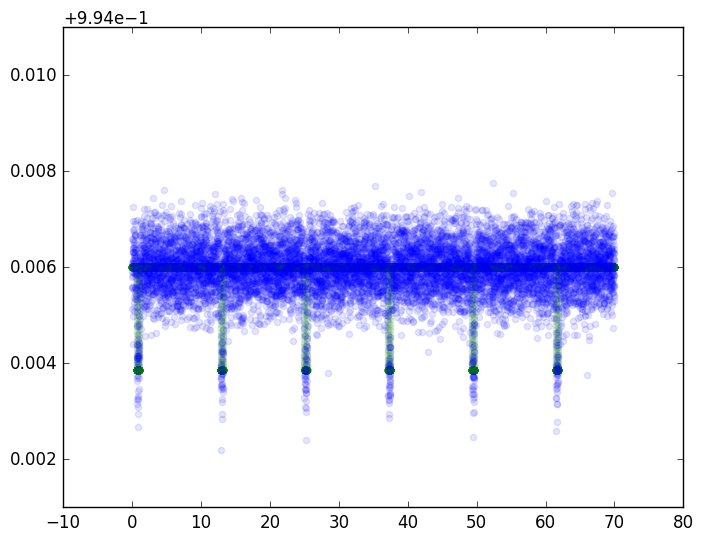

In [291]:
plot_results1(best_optim)

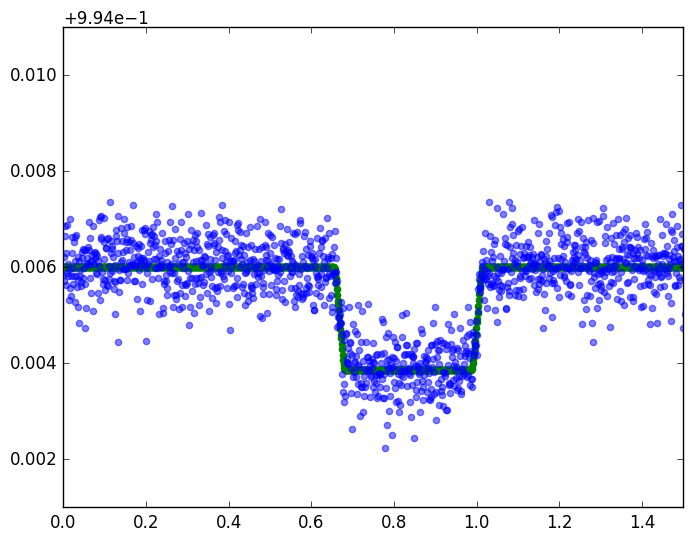

In [292]:
plot_results2(best_optim)

## Run MCMC with `Lora` (Not converging to reasonable solution)

In [236]:
p = BasicContMuvParameter(:p, logtarget=transit_loglike_observables)

model = likelihood_model(p, false)

# initial guess -- params [ dF, tT, tF, P, tE ]
params = [0.0025, 0.4, 0.2, best_period, best_toff]
#params = best_optim

sampler = MH(ones(length(params)))

N = 10000000
mcrange = BasicMCRange(nsteps=N, burnin=(Int(N/2)))

v0 = Dict(:p=>params)

job = BasicMCJob(model, sampler, mcrange, v0, tuner=AcceptanceRateMCTuner(0.8, verbose=false))

run(job)

chain = output(job)

### Check that the simulated values are close to the zero-mean target

best_mcmc = mean(chain)

5-element Array{Float64,1}:
  0.145082
  5.91207 
  0.81204 
 12.1628  
  0.465994

In [237]:
# params [ dF, tT, tF, P, tE ]

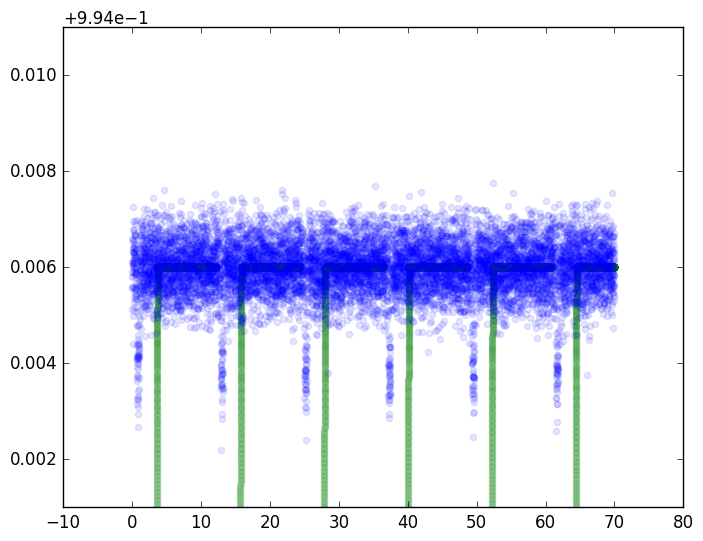

In [238]:
plot_results1(best_mcmc)

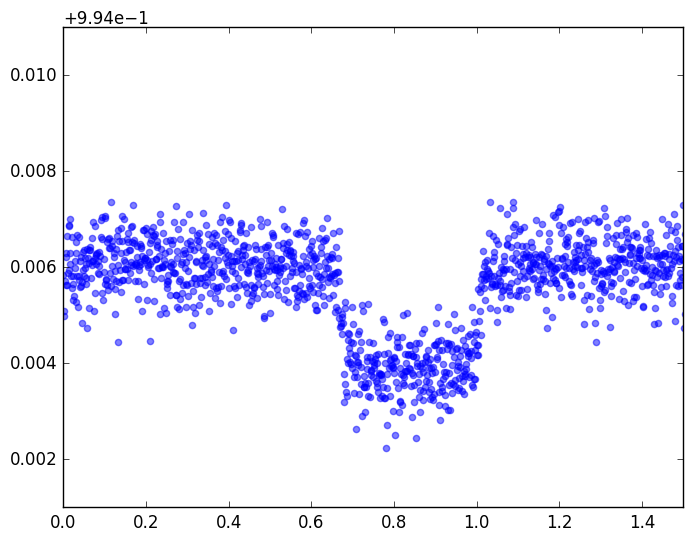

In [239]:
plot_results2(best_mcmc)

In [244]:
best_optim

5-element Array{Float64,1}:
  0.00212891
  0.348699  
  0.298401  
 12.1647    
  0.83449   

In [246]:
best_optim[2]*.8

0.2789591022637587